In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import sklearn

from sklearn import metrics
from scipy import stats
from collections import Counter

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# import torch
# torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
# print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

import training_utils.dataset_utils as data_utils
import training_utils.partitioning_utils as pat_utils

import importlib
import training_utils.train_utils as train_utils
importlib.reload(train_utils)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


IndentationError: unindent does not match any outer indentation level (train_utils.py, line 143)

In [ ]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/07_retraining_CLIP_using_metaanalysis_dataset_weights.ipynb"
import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

In [ ]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

In [ ]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

# batch_size = 20
learning_rate = 2e-5
EPOCHS = 15

## Retraining model from scratch

Retraining model from scratch with some adjustments:
1) peptide embedder was added so that both binder and target would not be parsed through the same network:
```python
        self.pep_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
```
2) in forward path final embeddings for both peptide and protein were:
```python
            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)
```
3) adding self.logit_bias
4) removing scaler (???)
5) adding pos_weight when calculating loss

Use `F.normalize` when you want unit-length embeddings for cosine similarity, retrieval, contrastive learning, or to control vector magnitude (e.g., sentence/image embeddings).

Use `nn.LayerNorm` inside networks (Transformers, RNNs, MLPs) to stabilize training by removing per-sample mean/variance across features.

In [2]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

## Embeddings paths
binders_embeddings = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
targets_embeddings = "/work3/s232958/data/meta_analysis/targets_embeddings_esmC"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [6]:
### Loading the dataset
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).reset_index(drop=True).drop(columns = ["target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not

### Weights for binder/non-binders
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["class_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
# binder_nonbinder_weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["class_weight"]))

### Weights for target
N_bins = len(interaction_df["target_id_mod"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["target_id_mod"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["target_weight"] = interaction_df.target_id_mod.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])

### Combined weights
interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Remove FGFR2
interaction_df_withoutFGFR2 = interaction_df[interaction_df.target_id_mod != "FGFR2"]
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553


### 5-fold CV training + weighting of samples

In [7]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [8]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


In [9]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    train_targets = cv_splits[idx][1]
    print(f"Fold {idx+1} : validation targets : {val_targets}")

Fold 1 : validation targets : ['FGFR2', 'Mdm2', 'LTK']
Fold 2 : validation targets : ['SARS_CoV2_RBD', 'sntx', 'sntx_2', 'IL7Ra']
Fold 3 : validation targets : ['InsulinR', 'TrkA', 'IL10Ra']
Fold 4 : validation targets : ['EGFR', 'EGFR_2', 'EGFR_3', 'VirB8']
Fold 5 : validation targets : ['IL2Ra', 'Pdl1']


In [10]:
interaction_df.loc[interaction_df.target_id_mod.isin(cv_splits[1][1])].binder.value_counts()

binder
False    2876
True      337
Name: count, dtype: int64

### Creating separate targets/ binder dataframes

In [11]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder", "class_weight", "target_weight", "combined_weight"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

### Class for loading binders/targets

In [14]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()+2
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                assert (embd.shape[0] == self.sequence_df.loc[accession].seq_len+2)
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_targets", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_binders", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:08<00:00, 409.94it/s]


In [14]:
# checking if _get_by_name function gives the same output as index used
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [15]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

In [16]:
### Combined weights (boost positives, reduce number of FGFR2 binder)
multipliers = []
for name in interaction_df["target_id_mod"]:
    if name == "FGFR2":
        multipliers.append(1)
    else:
        multipliers.append(10)
interaction_df["target_weight_FGFR2_reduced"] = interaction_df["target_weight"] * multipliers

### Combined weights
# interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Combined weights (boost positives)
multipliers = []
for binder in interaction_df["binder"]:
    if binder == False:
        multipliers.append(1)
    else:
        multipliers.append(5)
interaction_df["combined_weight_boost_pos"] = ((interaction_df["class_weight"]+interaction_df["target_weight_FGFR2_reduced"])/2) * multipliers

u = interaction_df[['binder', 'target_id_mod', 'combined_weight_boost_pos']].drop_duplicates(subset=['target_id_mod', 'binder'])
print(u.sort_values('target_id_mod').to_string(index=False))
# or as a dict:
weight_map = u.set_index('target_id_mod')['combined_weight_boost_pos'].to_dict()

 binder target_id_mod  combined_weight_boost_pos
   True          EGFR                   0.015404
  False          EGFR                   0.002521
   True        EGFR_2                   0.008371
  False        EGFR_2                   0.001114
   True        EGFR_3                   0.393822
  False         FGFR2                   0.000094
   True         FGFR2                   0.003271
   True        IL10Ra                   0.074220
  False        IL10Ra                   0.014284
   True         IL2Ra                   0.026871
  False         IL2Ra                   0.004814
  False         IL7Ra                   0.001907
   True         IL7Ra                   0.012334
   True      InsulinR                   0.016552
  False      InsulinR                   0.002751
  False           LTK                   0.009549
   True           LTK                   0.050545
  False          Mdm2                   0.003335
   True          Mdm2                   0.019473
   True          Pdl

In [17]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
train_weights_combined_boosted = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_sampler = WeightedRandomSampler(weights=train_weights_combined_boosted, num_samples=len(train_binders_ds), replacement=True, generator = g)
train_loader   = DataLoader(train_binders_ds,  batch_size=20, sampler=train_sampler)
# train_loader   = DataLoader(train_binders_ds,  batch_size=20, shuffle=True)

for bi, batch in enumerate(train_loader):
    if bi > 80:
        _, _, labels, ids = batch
        c = Counter(ids)
        print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    
    if bi == 90: break  # first 5 batches

Batch 81: {'IL2Ra': 2, 'Mdm2': 5, 'EGFR_2': 2, 'EGFR_3': 6, 'FGFR2': 1, 'VirB8': 2, 'EGFR': 1, 'Pdl1': 1}  | positives=13 / 20
Batch 82: {'LTK': 1, 'Mdm2': 3, 'EGFR_2': 2, 'EGFR_3': 6, 'FGFR2': 1, 'Pdl1': 1, 'TrkA': 1, 'InsulinR': 1, 'IL2Ra': 1, 'IL10Ra': 2, 'VirB8': 1}  | positives=14 / 20
Batch 83: {'EGFR_2': 1, 'VirB8': 3, 'IL2Ra': 1, 'Mdm2': 4, 'TrkA': 1, 'IL10Ra': 2, 'EGFR': 1, 'EGFR_3': 5, 'LTK': 1, 'FGFR2': 1}  | positives=12 / 20
Batch 84: {'EGFR': 1, 'EGFR_3': 3, 'Mdm2': 6, 'IL10Ra': 1, 'Pdl1': 2, 'VirB8': 3, 'InsulinR': 2, 'LTK': 1, 'FGFR2': 1}  | positives=14 / 20
Batch 85: {'TrkA': 1, 'InsulinR': 2, 'LTK': 1, 'FGFR2': 4, 'EGFR_3': 4, 'EGFR': 3, 'Mdm2': 3, 'EGFR_2': 1, 'Pdl1': 1}  | positives=14 / 20
Batch 86: {'EGFR_2': 4, 'InsulinR': 2, 'IL2Ra': 1, 'IL10Ra': 1, 'EGFR_3': 6, 'Mdm2': 3, 'VirB8': 1, 'FGFR2': 1, 'TrkA': 1}  | positives=13 / 20
Batch 87: {'EGFR_2': 2, 'LTK': 1, 'Pdl1': 1, 'EGFR_3': 5, 'IL10Ra': 1, 'Mdm2': 2, 'IL2Ra': 3, 'EGFR': 1, 'FGFR2': 2, 'InsulinR': 2}  | 

### Training class

In [18]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, pos_weight, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.pos_weight = pos_weight
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.pos_weight, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

# Training from scratch
### `pos_weight` added to loss calculation

Only CV-split-2 is used.
Adding pos_weight to loss calculation:


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 8.5402 | Val AUROC 0.4965 | Val AUPR 0.1588
EPOCH 1 - Train Loss 1.3489 | Val Loss 1.9891 | Val AUROC 0.3716 | Val AUPR 0.1292
EPOCH 2 - Train Loss 1.1341 | Val Loss 1.2003 | Val AUROC 0.3985 | Val AUPR 0.1345
EPOCH 3 - Train Loss 1.1303 | Val Loss 1.8692 | Val AUROC 0.3885 | Val AUPR 0.1326
EPOCH 4 - Train Loss 1.0717 | Val Loss 1.5685 | Val AUROC 0.4075 | Val AUPR 0.1354
EPOCH 5 - Train Loss 1.0168 | Val Loss 1.7571 | Val AUROC 0.3845 | Val AUPR 0.1307


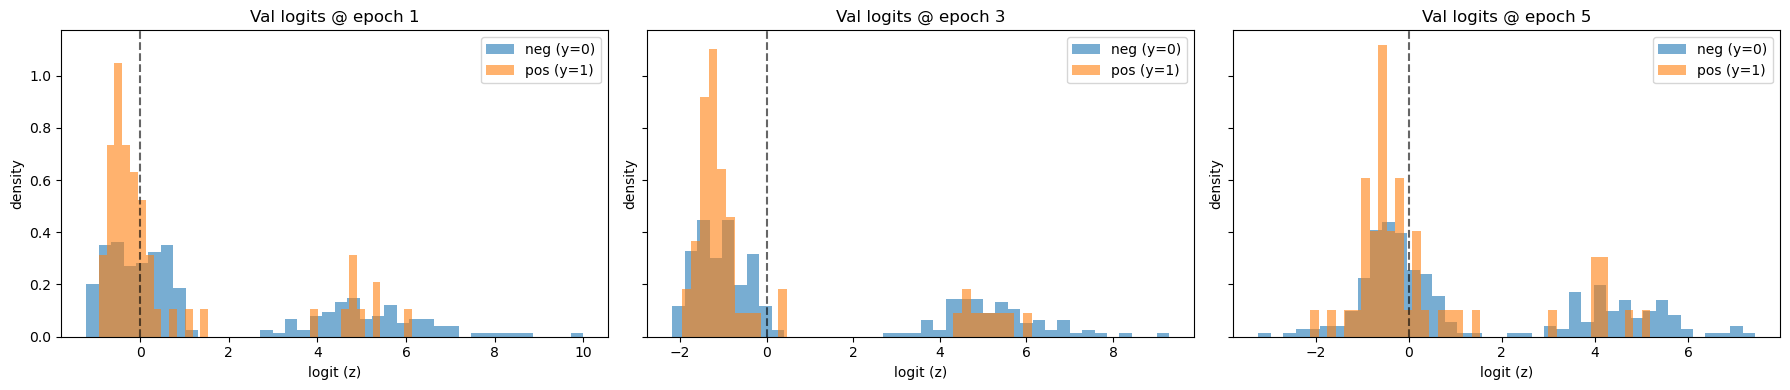

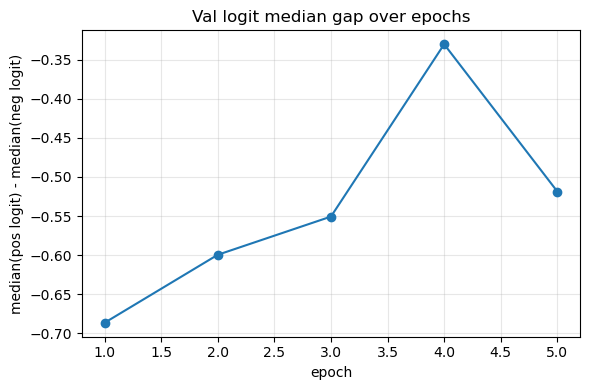

Train Loss,█▃▃▂▁
Val AUPR,█▁▂▂▂▁
Val AUROC,█▁▃▂▃▂
Val Loss,█▂▁▂▁▂
val_logit_gap,▁▃▄█▄
val_neg_median_logit,█▂▄▁▇
val_pos_median_logit,█▁▃▁▇
Train Loss,1.01675
Val AUPR,0.13067
Val AUROC,0.38449
Val Loss,1.75713


In [19]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        # self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        # self.pep_embedder = nn.Sequential(
        #     nn.Linear(self.embed_dimension, 640),
        #     nn.ReLU(),
        #     nn.Linear(640, 320),
        # )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            # pep_emb  = self.norm(prot_emb  + pep_trans  + pep_cross)
            # prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

print("Only CV-split-2 is used.")
print("Adding pos_weight to loss calculation:")

batch_size = 20
learning_rate = 2e-5
EPOCHS = 5
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

for i in range(1, 2):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders,   batch_size=32, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_pos_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

#### Flipping logits sign:

In [20]:
model = MiniCLIP_w_transformer_crossattn().to(device)
val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

with torch.no_grad():
    batch = next(iter(val_loader))
    loss, logits, labels = model.validation_step(batch, device)
    y = labels.float()
    print('median logit(y=1) - median logit(y=0) =', logits[y==1].median().item() - logits[y==0].median().item())
    batch2 = next(iter(val_loader))
    loss2, logits2, labels2 = model.validation_step(batch, device)

# try AUROC with flipped sign once
auroc_normal = sklearn.metrics.roc_auc_score(y.cpu(), logits.cpu())
auroc_flipped = sklearn.metrics.roc_auc_score(y.cpu(), (-logits).cpu())
print(f"AUC when logits are not flipped: {auroc_normal}, \nAUC after flipping logits: {auroc_flipped}")
# print('gap:', logits2[y==1].median().item() - logits2[y==0].median().item())

median logit(y=1) - median logit(y=0) = -0.9604301452636719
AUC when logits are not flipped: 0.3125, 
AUC after flipping logits: 0.6875


#### Flipping logits sign for pretrained model:

In [21]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
pretrained_model = MiniCLIP_w_transformer_crossattn()
pretrained_model.load_state_dict(checkpoint['model_state_dict'])
pretrained_model.to(device)
val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

with torch.no_grad():
    batch = next(iter(val_loader))
    loss, logits, labels = pretrained_model.validation_step(batch, device)
    y = labels.float()
    print('median logit(y=1) - median logit(y=0) =', logits[y==1].median().item() - logits[y==0].median().item())
    batch2 = next(iter(val_loader))
    loss2, logits2, labels2 = pretrained_model.validation_step(batch, device)

# try AUROC with flipped sign once
auroc_normal = sklearn.metrics.roc_auc_score(y.cpu(), logits.cpu())
auroc_flipped = sklearn.metrics.roc_auc_score(y.cpu(), (-logits).cpu())
print(f"AUC when logits are not flipped: {auroc_normal}, \nAUC after flipping logits: {auroc_flipped}")
# print('gap:', logits2[y==1].median().item() - logits2[y==0].median().item())

median logit(y=1) - median logit(y=0) = -0.4856398105621338
AUC when logits are not flipped: 0.609375, 
AUC after flipping logits: 0.390625


Only CV-split-1 is used.
Adding pos_weight to loss calculation:


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 9.5343 | Val AUROC 0.4559 | Val AUPR 0.1097
EPOCH 1 - Train Loss 1.8530 | Val Loss 0.3618 | Val AUROC 0.6000 | Val AUPR 0.1689
EPOCH 2 - Train Loss 1.2525 | Val Loss 0.5772 | Val AUROC 0.6681 | Val AUPR 0.2439
EPOCH 3 - Train Loss 1.1362 | Val Loss 0.9457 | Val AUROC 0.6198 | Val AUPR 0.2277
EPOCH 4 - Train Loss 1.1312 | Val Loss 0.5285 | Val AUROC 0.6482 | Val AUPR 0.2195
EPOCH 5 - Train Loss 1.1186 | Val Loss 0.5520 | Val AUROC 0.6553 | Val AUPR 0.2558


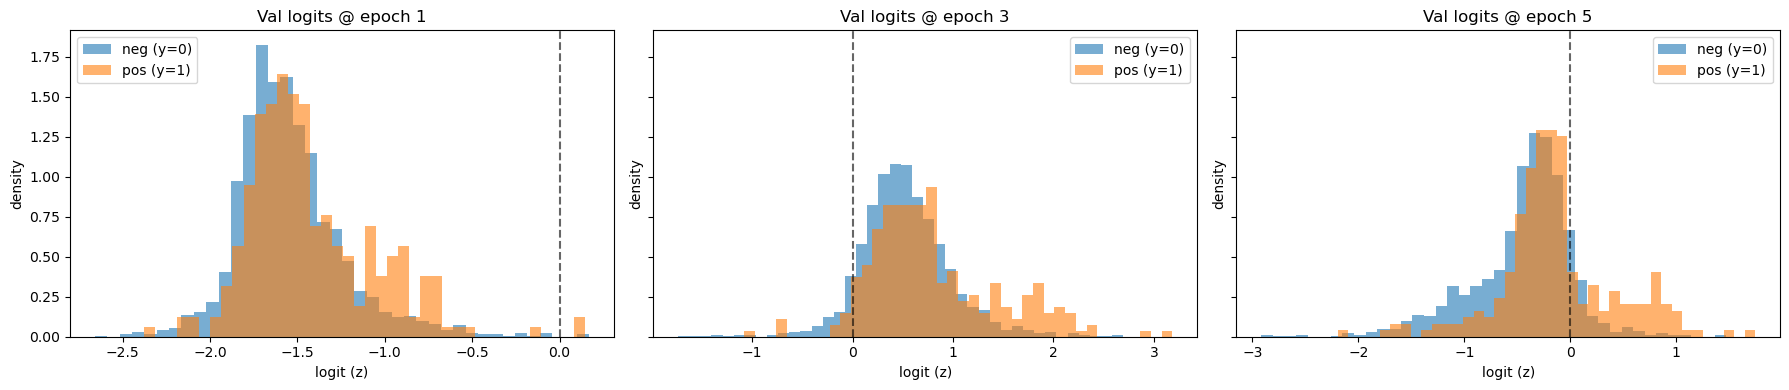

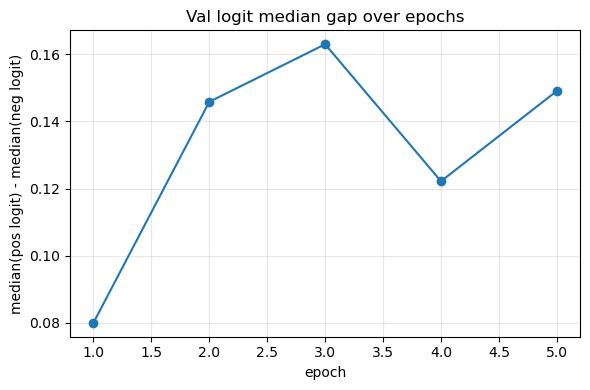

Train Loss,█▂▁▁▁
Val AUPR,▁▄▇▇▆█
Val AUROC,▁▆█▆▇█
Val Loss,█▁▁▁▁▁
val_logit_gap,▁▇█▅▇
val_neg_median_logit,▁▆█▅▅
val_pos_median_logit,▁▆█▅▅
Train Loss,1.11857
Val AUPR,0.25584
Val AUROC,0.6553
Val Loss,0.552


In [22]:
print("Only CV-split-1 is used.")
print("Adding pos_weight to loss calculation:")

for i in range(0, 1):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders,   batch_size=32, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_pos_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

### `self.pep_embedder` for peptide + `pos_weight` +  `self.logit_bias`

Only CV-split-2 is used.
Adding pos_weight to loss calculation:


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 1.3099 | Val AUROC 0.3639 | Val AUPR 0.1261
EPOCH 1 - Train Loss 1.2440 | Val Loss 0.6990 | Val AUROC 0.5604 | Val AUPR 0.2192
EPOCH 2 - Train Loss 1.1489 | Val Loss 0.5687 | Val AUROC 0.5239 | Val AUPR 0.1819
EPOCH 3 - Train Loss 1.1024 | Val Loss 0.5497 | Val AUROC 0.4323 | Val AUPR 0.1691
EPOCH 4 - Train Loss 1.0339 | Val Loss 0.6880 | Val AUROC 0.4370 | Val AUPR 0.1566
EPOCH 5 - Train Loss 1.0174 | Val Loss 0.6254 | Val AUROC 0.4397 | Val AUPR 0.1688


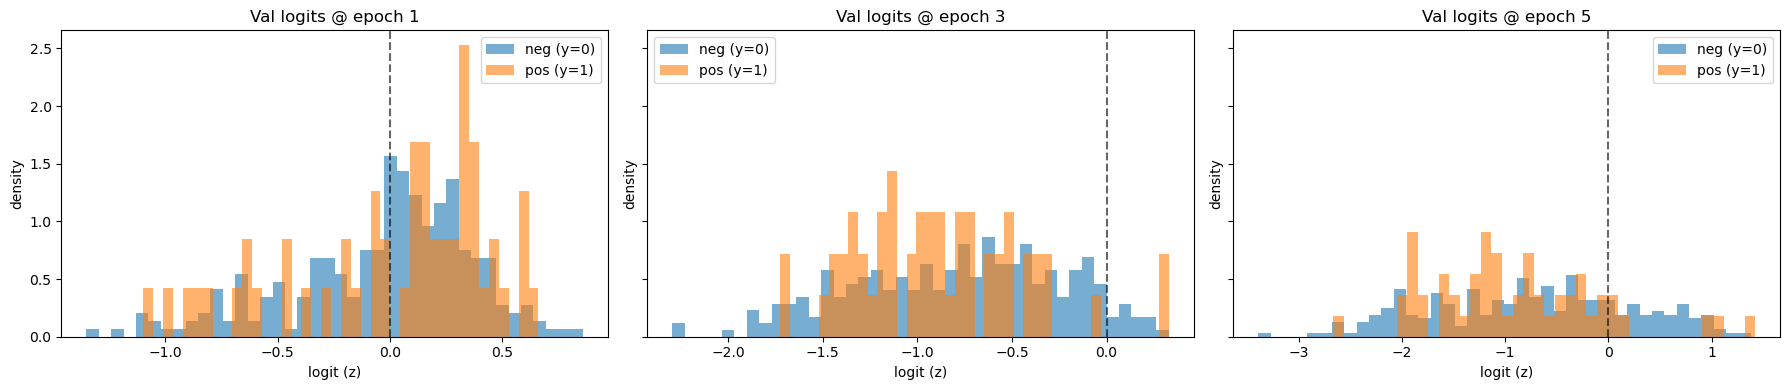

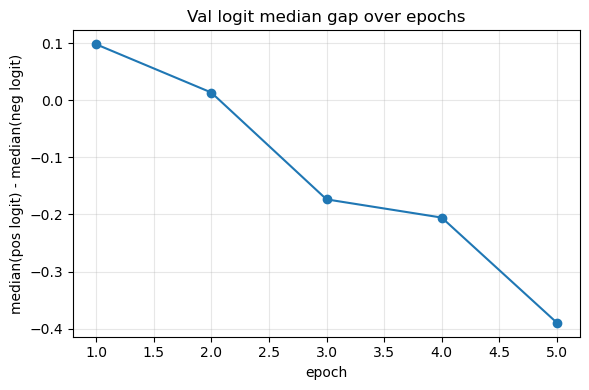

Train Loss,█▅▄▂▁
Val AUPR,▁█▅▄▃▄
Val AUROC,▁█▇▃▄▄
Val Loss,█▂▁▁▂▂
val_logit_gap,█▇▄▄▁
val_neg_median_logit,█▃▁▆▁
val_pos_median_logit,█▄▂▅▁
Train Loss,1.01741
Val AUPR,0.16879
Val AUROC,0.43969
Val Loss,0.62545


In [23]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        self.pep_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            # pep_emb = pep_emb + pep_cross  
            # prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.pep_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) + self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

print("Only CV-split-2 is used.")
print("Adding pos_weight to loss calculation:")

batch_size = 20
learning_rate = 2e-5
EPOCHS = 5
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

for i in range(1, 2):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders,   batch_size=32, sampler=train_sampler)
    
    val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_pep_embeder_posweight_logit_bias",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

### `self.pep_embedder` for peptide + `pos_weight` +  `self.logit_bias` + flipping sign for logits (???)

Only CV-split-2 is used.
Adding pos_weight to loss calculation:


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 1.0664 | Val AUROC 0.4449 | Val AUPR 0.1715
EPOCH 1 - Train Loss 1.2148 | Val Loss 0.6138 | Val AUROC 0.4911 | Val AUPR 0.1717
EPOCH 2 - Train Loss 1.0929 | Val Loss 0.4857 | Val AUROC 0.4614 | Val AUPR 0.1765
EPOCH 3 - Train Loss 1.0775 | Val Loss 0.5302 | Val AUROC 0.5444 | Val AUPR 0.1927
EPOCH 4 - Train Loss 1.0387 | Val Loss 1.0124 | Val AUROC 0.4891 | Val AUPR 0.1739
EPOCH 5 - Train Loss 1.0440 | Val Loss 0.6752 | Val AUROC 0.4927 | Val AUPR 0.1850


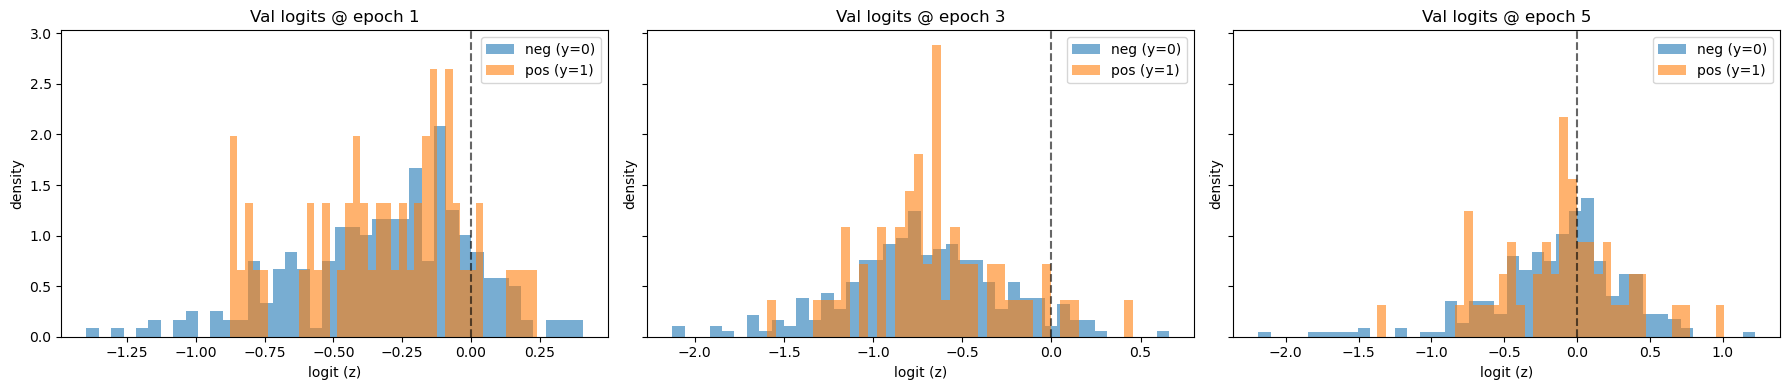

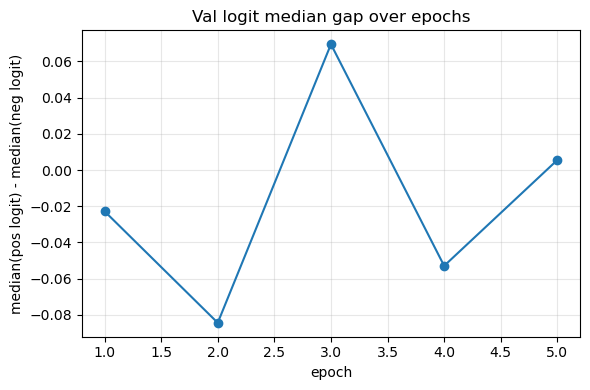

Train Loss,█▃▃▁▁
Val AUPR,▁▁▃█▂▅
Val AUROC,▁▄▂█▄▄
Val Loss,█▃▁▂▇▃
val_logit_gap,▄▁█▂▅
val_neg_median_logit,▄▁▃█▅
val_pos_median_logit,▅▁▃█▅
Train Loss,1.04401
Val AUPR,0.18497
Val AUROC,0.49273
Val Loss,0.67523


In [25]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        self.pep_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            # pep_emb = pep_emb + pep_cross  
            # prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.pep_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) + self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(-logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(-logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(-logits, binder_labels)
    
        return float(loss), -logits, binder_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

print("Only CV-split-2 is used.")
print("Adding pos_weight to loss calculation:")

batch_size = 20
learning_rate = 2e-5
EPOCHS = 5
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

for i in range(1, 2):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders,   batch_size=32, sampler=train_sampler)
    
    val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_flipLogits_pep_embeder_posweight_logit_bias",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

### `self.pep_embedder` for peptide + `self.logit_bias` + weighted sampling

Only CV-split-2 is used.
Adding pos_weight to loss calculation:


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 1.0856 | Val AUROC 0.4193 | Val AUPR 0.1407
EPOCH 1 - Train Loss 0.4715 | Val Loss 0.5800 | Val AUROC 0.4049 | Val AUPR 0.1351
EPOCH 2 - Train Loss 0.3280 | Val Loss 0.7665 | Val AUROC 0.3830 | Val AUPR 0.1295
EPOCH 3 - Train Loss 0.2739 | Val Loss 0.5441 | Val AUROC 0.4900 | Val AUPR 0.1647
EPOCH 4 - Train Loss 0.2113 | Val Loss 0.8168 | Val AUROC 0.3570 | Val AUPR 0.1262
EPOCH 5 - Train Loss 0.1471 | Val Loss 0.8438 | Val AUROC 0.3655 | Val AUPR 0.1380


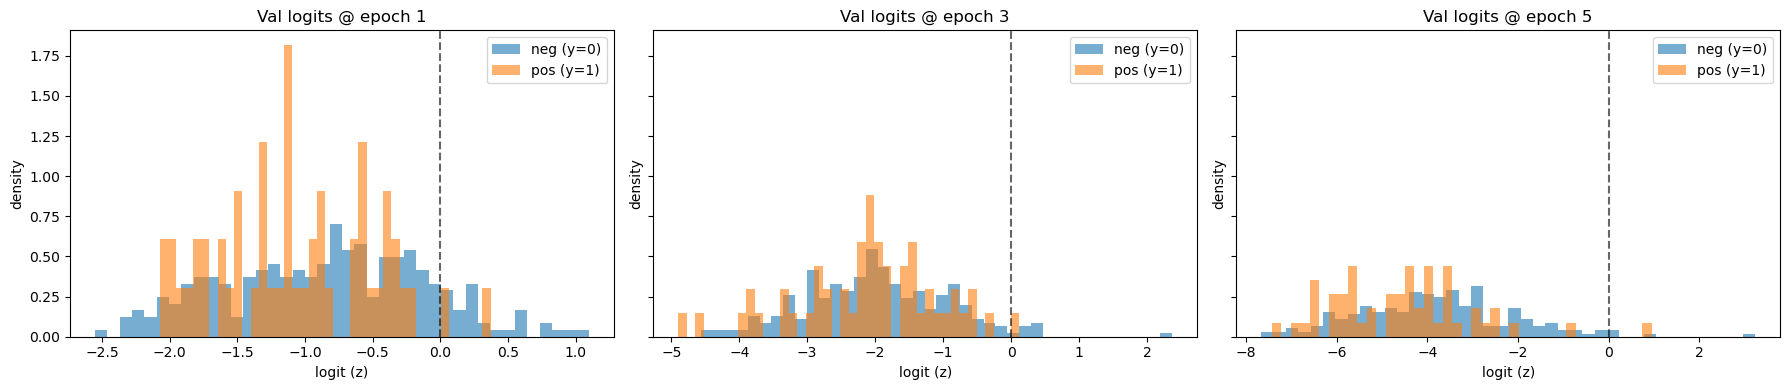

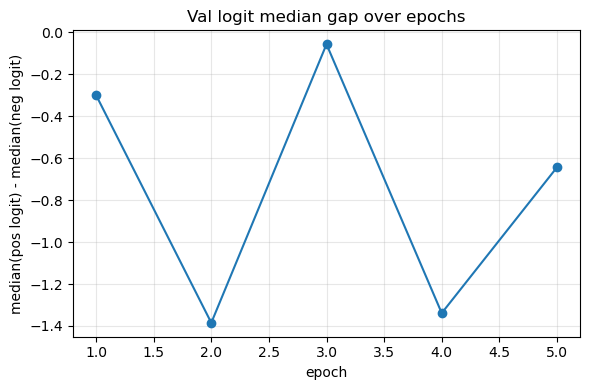

Train Loss,█▅▄▂▁
Val AUPR,▄▃▂█▁▃
Val AUROC,▄▄▂█▁▁
Val Loss,█▁▄▁▅▅
val_logit_gap,▇▁█▁▅
val_neg_median_logit,█▅▅▃▁
val_pos_median_logit,█▃▆▁▁
Train Loss,0.14712
Val AUPR,0.13804
Val AUROC,0.36548
Val Loss,0.84377


In [28]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        self.pep_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            # pep_emb = pep_emb + pep_cross  
            # prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.pep_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) + self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

print("Only CV-split-2 is used.")
print("Adding pos_weight to loss calculation:")

batch_size = 20
learning_rate = 2e-5
EPOCHS = 5
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

for i in range(1, 2):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_weighted_sampling_pep_embeder_logit_bias",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = None,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

# Pretarined model
### `self.pep_embedder` for peptide + `pos_weight` +  `self.logit_bias`

Only CV-split-2 is used.


Training model 6c17c38e-96db-4acb-b9e1-457fa68fe34e
Before training - Val Loss 8.8085 | Val AUROC 0.4711 | Val AUPR 0.1493
EPOCH 1 - Train Loss 1.3848 | Val Loss 1.6572 | Val AUROC 0.3614 | Val AUPR 0.1280
EPOCH 2 - Train Loss 1.1676 | Val Loss 2.5989 | Val AUROC 0.4018 | Val AUPR 0.1345
EPOCH 3 - Train Loss 1.0882 | Val Loss 1.3254 | Val AUROC 0.3820 | Val AUPR 0.1320
EPOCH 4 - Train Loss 1.0832 | Val Loss 1.9043 | Val AUROC 0.3766 | Val AUPR 0.1302
EPOCH 5 - Train Loss 1.0426 | Val Loss 1.6222 | Val AUROC 0.3752 | Val AUPR 0.1302


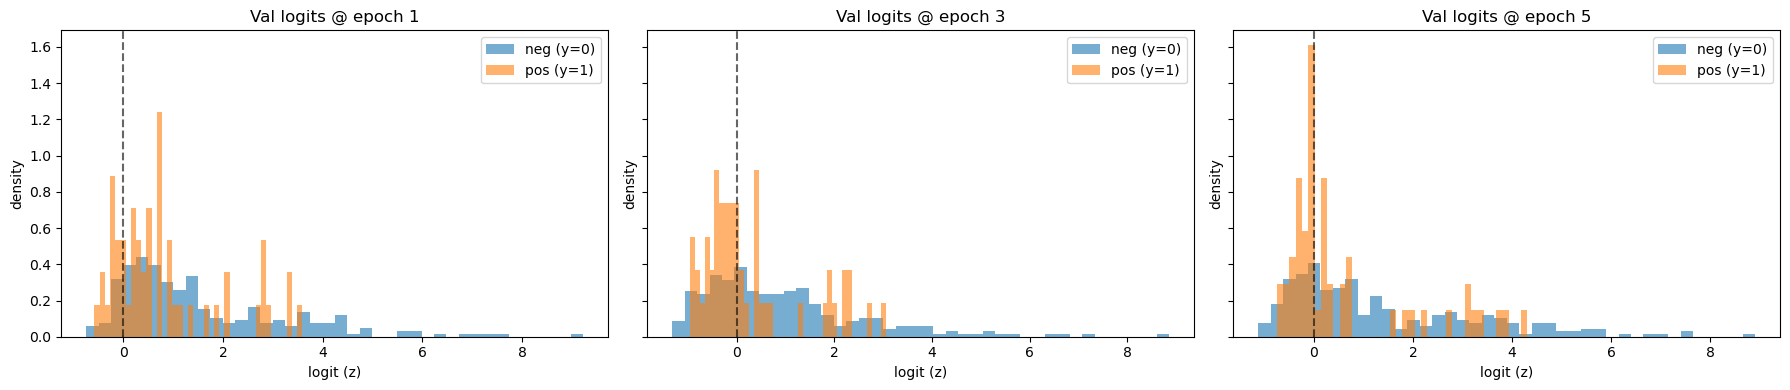

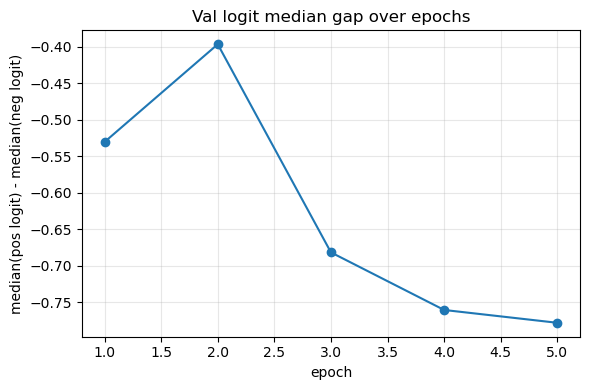

Train Loss,█▄▂▂▁
Val AUPR,█▁▃▂▂▂
Val AUROC,█▁▄▂▂▂
Val Loss,█▁▂▁▂▁
val_logit_gap,▆█▃▁▁
val_neg_median_logit,▃█▁▅▂
val_pos_median_logit,▃█▁▄▁
Train Loss,1.04259
Val AUPR,0.13022
Val AUROC,0.37519
Val Loss,1.6222


In [30]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            # pep_emb = pep_emb + pep_cross  
            # prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

print("Only CV-split-2 is used.")

batch_size = 20
learning_rate = 2e-5
EPOCHS = 5
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

for i in range(1, 2):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders,   batch_size=32, sampler=train_sampler)
    
    val_loader = DataLoader(val_binders,  batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="MetaAnal_retraining_some_adjustments",
            name=f"CV_split{i+1}_pretrained",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass